<a href="https://colab.research.google.com/github/jmestanza/Guia_2_PASA/blob/master/Guia_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 22.46 Procesamiento Adaptativo de Señales Aleatorias
## Laboratorio de filtrado óptimo
## Grupo 2: Mestanza, Joaquín; Romarís, Juan Manuel


##Imports de Paquetes utilizados y definición de Funciones

In [0]:
%cd /content
from IPython.display import clear_output
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/sweep_rapido.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/sweep_lento.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/cuadrada.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/music_original.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/ruido_blanco_c.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/voice_48k.wav"

!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_sweep_rapido.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_sweep_lento.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_cuadrada.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_cassiopeia.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_ruido_blanco.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_voice.wav"

!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/music_signal.wav"
!pip install -U pip setuptools
!ls
clear_output()

import warnings
warnings.filterwarnings("ignore")
from scipy.io.wavfile import read
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import wave, struct, math, random
from IPython.display import Audio
from scipy import signal as sgn
from scipy.linalg import toeplitz
from scipy import linalg
from scipy import signal
from scipy.io.wavfile import write

Definimos algunas funcionas auxiliares para la lectura de los archivos de audio y de ploteo de datos

In [2]:
!pip install soundfile
import soundfile as sf
def fast_plot(data):
    plt.plot(range(len(data)),data)
def normalize(datos):
    return np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
def get_mono_array(stereo_file_name):
    file = read(stereo_file_name)
    fs = file[0]
    datos = np.array(file[1],dtype=float) 
    if len(np.shape(datos))>1: #si tiene dos canales
        ch0 = datos[:, 0]
        ch1 = datos[:, 1]
        datos = (ch0 + ch1)/2  # o lo hacemos mono
    return fs, datos


###Lectura de archivos de audio
En el diccionario a continuación para un dado tipo de audio se encuentran su audio original, grabado, desfase temporal entre grabación y original, y finalmente la duración total efectiva del evento grabado. Estos últimos datos serán utilizados para sincronizar los audios y lograr mejores resultados en el filtrado óptimo

In [0]:
# Obtenemos los datos de sweep logaritmico
clear_output()

##Ordenes para probar el filtro
Ms = [i for i in range(1,11)]
Ms = np.concatenate((Ms,[10*i for i in range(2,11)]))
Ms = np.concatenate((Ms,[100*i for i in range(2,11)]))
Ms = np.concatenate((Ms,[1000*i for i in range(2,11)]))

##Defino un diccionario con los nombres de archivos de entrada y deseada para cada señal, junto con la diferencia de tiempo para sincronizar
signals = {'lin':['/content/sweep_rapido.wav','/content/grab_sweep_rapido.wav',0.336,7.977],
          'log':['/content/sweep_lento.wav','/content/grab_sweep_lento.wav',0.648,10.936],
          'square':['/content/cuadrada.wav','/content/grab_cuadrada.wav',0.341,7.345],
          'noise':['/content/ruido_blanco_c.wav','/content/grab_ruido_blanco.wav',0.665, 8.339],
          'voice':['/content/voice_48k.wav','/content/grab_voice.wav',0.636,5.070],
          'music':['/content/music_original.wav','/content/grab_cassiopeia.wav',0.364,7.971]}

###Definición de funciones utilizadas

In [0]:
#Funciòn utilizada para leer un archivo wav
def read_wav(grab_file):
  file_name = grab_file
  fs, grab_audio = get_mono_array(file_name)
  grab_audio /= np.max(np.abs(grab_audio),axis=0)
  grab_audio /= np.max(np.abs(grab_audio),axis=0)
  grab_audio = grab_audio - np.mean(grab_audio)
  print("fs de la grabacion ",fs, "nombre", file_name)
  return grab_audio,fs

#Funciòn utilizada para leer los archivos wavs de audio
def read_wavs(audio_file,grab_file):
  file_name = grab_file
  fs, grab_audio = get_mono_array(file_name)
  grab_audio /= np.max(np.abs(grab_audio),axis=0)
  grab_audio /= np.max(np.abs(grab_audio),axis=0)
  grab_audio = grab_audio - np.mean(grab_audio)
  print("fs de la grabacion ",fs, "nombre", file_name)

  file_name = audio_file
  fs, audio = get_mono_array(file_name)

  audio /= np.max(np.abs(audio),axis=0)
  audio = audio-np.mean(audio)
  print("fs del audio ",fs, "nombre", file_name)
  return audio,grab_audio,fs

#Función utilizada para realizar el sincronizamiento entre los audios grabados y originales
def sync_signals(u,d,init_delay,evLen,fs):
    u = u[int(0):int((evLen)*fs)]
    d = d[int((init_delay)*fs):int((init_delay+evLen)*fs)]
    return u, d

#Función utilizada para ajustar diferencias en longitud de los audios sincronizados
def adjustSignals(fs,u,d):
    ##Agrego ceros si alguna señal tiene diferente tamaño
    diff = len(u) - len(d)
    if(diff > 0):
        d = np.concatenate((d,[0 for _ in range(diff)]))
    elif(diff < 0):
        u = np.concatenate((u,[0 for _ in range(-diff)]))

    ##Agrego un segundo de ceros al principio y al final
    uZ = np.array([0 for i in range(0,1*fs)])
    uZ = np.concatenate((uZ,u))
    uZ = np.concatenate((uZ,[0 for i in range(0,1*fs)]))

    dZ = np.array([0 for i in range(0,1*fs)])
    dZ = np.concatenate((dZ,d))
    dZ = np.concatenate((dZ,[0 for i in range(0,1*fs)]))
    return uZ,dZ

#Función en la que para una entrada u y una deseada d se estiman la autocorrealción rx de u, la cruzada entre u y d y la varianza de la señal deseada
def get_estimations(u,d):
    u_f = np.fft.fft(u)
    d_f = np.fft.fft(d)
    
    ##Estimo rx
    r = np.fft.ifft(u_f * u_f.conj()).real
    r = r[:len(u)//2]/len(u)
    ##Estimo p
    p = np.fft.ifft(u_f * d_f.conj()).real
    p = p[len(u)//2:]/len(u)
    p = np.flip(p)

    ##Estimo la energia de d
    s2d = np.var(d)
    return r,p,s2d

#Habiendo obtenido rx,p y la varianza de la señal deseada, para un M dado se obtienen los coeficientes del filtro óptimo y el valor de Jmin asociado
def get_filter(rx,p,M,sigma2d):
    rx1=rx[0:M]
    p1=p[0:M]
    R = toeplitz(rx1)
# se obtienen los coeficientes wo
    wo = np.dot(linalg.inv(R), p1)
    Jmin = sigma2d - p1.dot(wo)
    return rx1,R,p1,wo,Jmin

#Función que grafica el histograma de un conjunto de autovalores dados
def eigenvalues_dist(eigens,sound):
    plt.figure()
    plt.hist(eigens, bins=40)
    plt.title("Distribución de autovalores para entrada : "+ sound)
    plt.ylabel('Autovalores de R para  ' + sound, fontsize=14)
    plt.show()


##Cálculo del filtro óptimo para distintos audios



###Entrada Sweep Logarítmico
En primer lugar se consideró obtener el filtro óptimo para la señal asociada a un sweep logarítmico en frecuencia de una señal senoidal entre 20Hz y 20kHz. Se obtuvo el filtro de Wiener para distintas longitudes M y se graficó la relación entre el orden del filtro y el valor de Jmin para poder encontrar un valor de coeficiente óptimo.

fs de la grabacion  48000 nombre /content/grab_sweep_lento.wav
fs del audio  48000 nombre /content/sweep_lento.wav


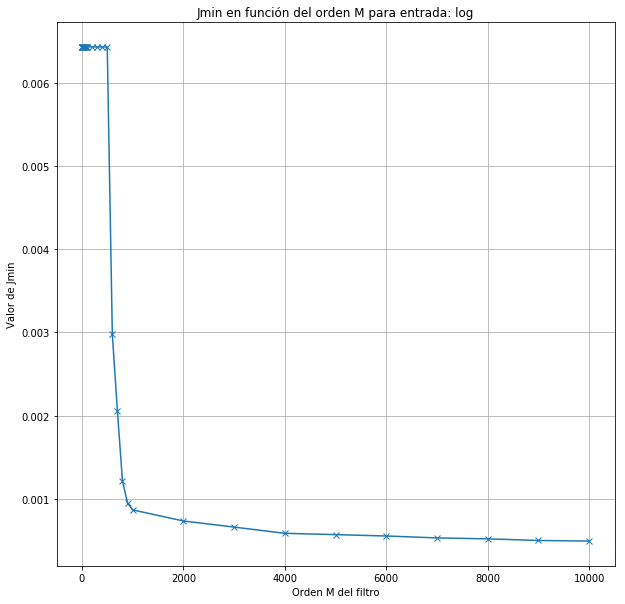

In [49]:
sound="log"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)

r, p, sigma2d = get_estimations(uZ,dZ)
Jmin = np.zeros(len(Ms))
for i,M in enumerate(Ms):
  r1,R,p1,wo,Jmin[i]= get_filter(r,p,M,sigma2d)

estimado = signal.filtfilt(wo,[1],u)

#Gráfico de Jmin en función de M
plt.figure(figsize=[10,10])
plt.title("Jmin en función del orden M para entrada: "+ sound)
plt.xlabel("Orden M del filtro")
plt.ylabel("Valor de Jmin")
plt.grid(True)
plt.plot(Ms,Jmin, marker='x')

Como era esperado se observa que a medida que aumenta el orden del filtro Jmin se reduce. Se observa un múy rapido descenso del mismo cercano al caso del filtro de orden 1000. A paritr del caso del filtro de orden 4000 la mejora en relación a Jmin se va reduciendo. Teniendo en cuenta esto se toma como un valor de M óptimo 8000 coeficientes. A medida que el orden del filtro aumenta no se observan mejoras notorias respecto a Jmin.
Para este valor óptimo a continuación se obtiene el valor de Epsilon para la situación.

In [50]:
Mopt=8000
r1,R1,p1,wo,Jminim= get_filter(r,p,Mopt,sigma2d)
print("El valor de Epsilon  para el M óptimo es: ",Jminim/sigma2d)

El valor de Epsilon  para el M óptimo es:  0.07758712302682977


Además se obtienen los autovalores de la matriz R y se obtiene un histograma de ellos

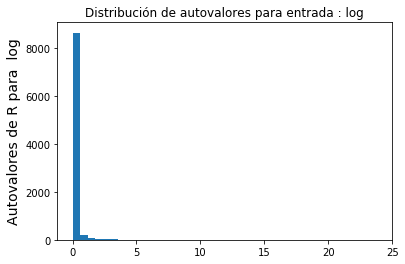

In [51]:
aval = linalg.eigvalsh(R1)
eigenvalues_dist(aval,sound)

Finalmente se considera filtrar la señal de audio original por el filtro obtenido y compararla con el audio grabado con el fin de poder visualizar su correspondencia. Además se obtiene la señal de audio filtrada para ser escuchada

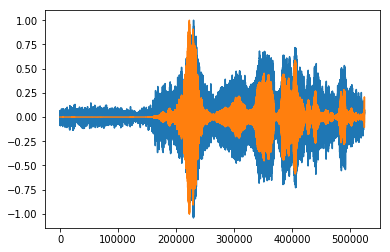

In [52]:
estimado = signal.filtfilt(wo,[1],u)
d = d/max(d)
estimado = estimado/max(estimado)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

In [53]:
Audio(estimado,rate=fs)

###Entrada Sweep Lineal
A continuación se consideró realizar el mismo procedimiento para una sweep lineal en frecuencia de una señal senoidal.

fs de la grabacion  48000 nombre /content/grab_sweep_rapido.wav
fs del audio  48000 nombre /content/sweep_rapido.wav


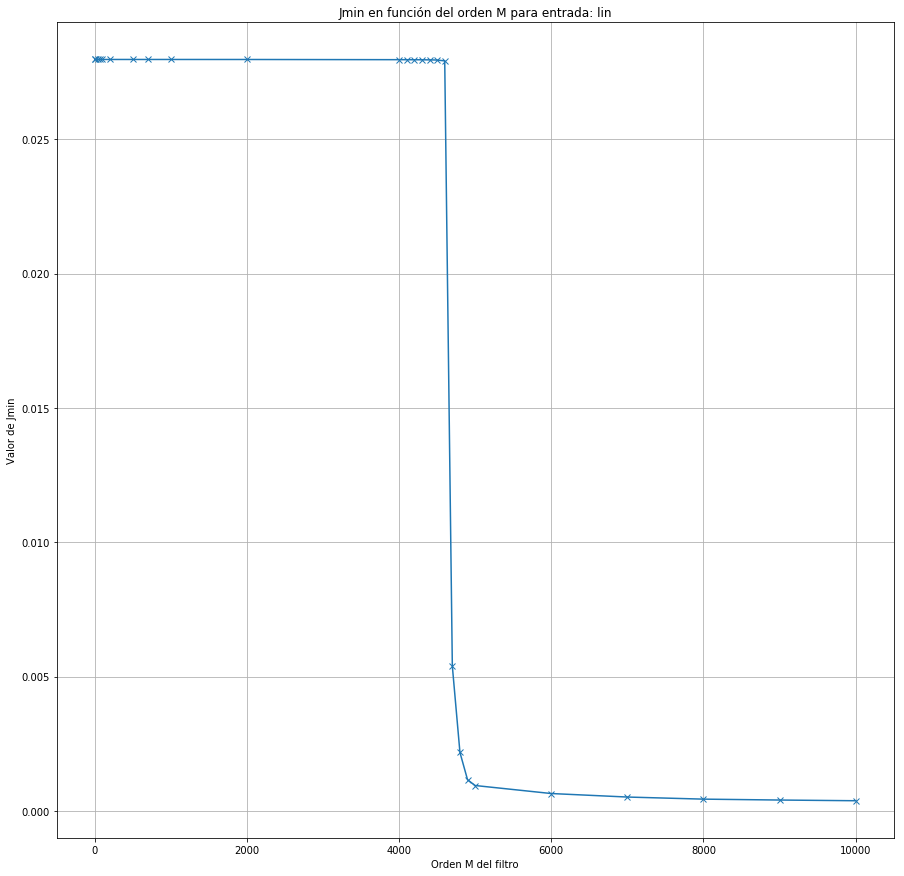

In [7]:
Ms = [1,10,50,70,100,200,500,700,1000,2000,4000,4100,4200,4300,4400,4500,4600,4700,4800,4900,5000,6000,7000,8000,9000,10000]

sound="lin"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)


r, p, sigma2d = get_estimations(uZ,dZ)
Jmin = np.zeros(len(Ms))
for i,M in enumerate(Ms):
  r1,R,p1,wo,Jmin[i]= get_filter(r,p,M,sigma2d)

plt.figure(figsize=[15,15])
plt.title("Jmin en función del orden M para entrada: "+ sound)
plt.xlabel("Orden M del filtro")
plt.ylabel("Valor de Jmin")
plt.grid(True)
plt.plot(Ms,Jmin, marker='x')

Para esta señal se observa que también hay una mejora abrupta de Jmin en función de M. Sin embargo esta mejora ocurre mucho mas tarde cercana a M=5000. Respecto al M òptimo se ve que tras esta mejora abrupta Jmin no mejora de manera pronunciada. Como valor de M òptimo vuelve a tomarse el valor de 8000 coeficientes. Para este valor óptimo se obtuvo el valor de epsilon asociado.

In [8]:
Mopt=8000
r1,R1,p1,wo,Jminim= get_filter(r,p,Mopt,sigma2d)
woF=wo
estimado = signal.filtfilt(wo,[1],u)
print("El valor de Epsilon  para el M óptimo es: ",Jminim/sigma2d)

El valor de Epsilon  para el M óptimo es:  0.015838227927895663


Además se obtienen los autovalores de la matriz R y se obtiene un histograma de ellos

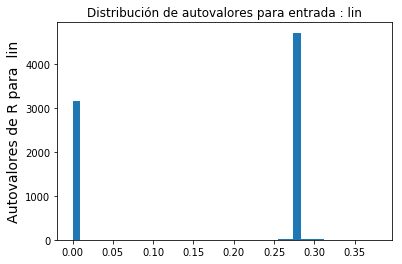

In [56]:
aval = linalg.eigvalsh(R1)
eigenvalues_dist(aval,sound)

Finalmente se considera filtrar la señal de audio original por el filtro obtenido y compararla con el audio grabado con el fin de poder visualizar su correspondencia. Además se obtiene la señal de audio filtrada para ser escuchada

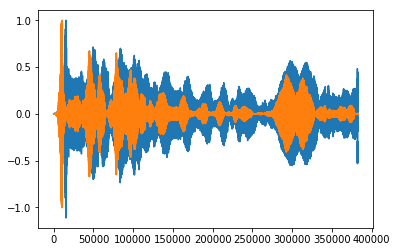

In [57]:
estimado = signal.filtfilt(wo,[1],u)
d = d/max(d)
estimado = estimado/max(estimado)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

In [58]:
Audio(estimado,rate=fs)

###Entrada Señal Cuadrada
Tras el sweep lineal se consideró estimar el filtro óptimo para una entrada cuadrada.

fs de la grabacion  48000 nombre /content/grab_cuadrada.wav
fs del audio  48000 nombre /content/cuadrada.wav


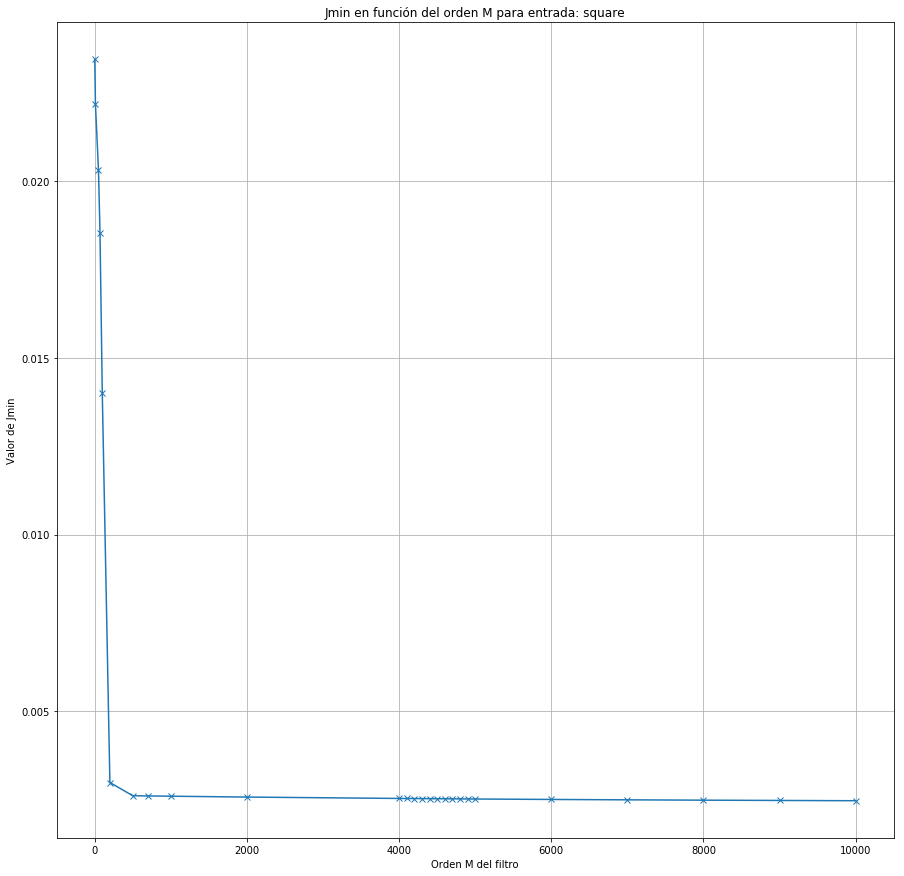

In [59]:
sound="square"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)

r, p, sigma2d = get_estimations(uZ,dZ)
Jmin = np.zeros(len(Ms))
for i,M in enumerate(Ms):
  r1,R,p1,wo,Jmin[i]= get_filter(r,p,M,sigma2d)

plt.figure(figsize=[15,15])
plt.title("Jmin en función del orden M para entrada: "+ sound)
plt.xlabel("Orden M del filtro")
plt.ylabel("Valor de Jmin")
plt.grid(True)
plt.plot(Ms,Jmin, marker='x')

La mejora respecto a Jmin es muy veloz respecto al orden del filtro utilizado. Se observa que ya para un filtro de orden 100 Jmin mejora de una manera muy notoria. Para ordenes del filtro mayores no se ven mejoras notables. Teniendo en cuenta esto se toma como el valor óptimo de M= 1000. Para este valor se consideró obtener el valor del epsilon asociado

In [60]:
Mopt=1000
r1,R1,p1,wo,Jminim= get_filter(r,p,Mopt,sigma2d)
estimado = signal.filtfilt(wo,[1],u)
print("El valor de Epsilon  para el M óptimo es: ",Jminim/sigma2d)

El valor de Epsilon  para el M óptimo es:  0.11029612986896799


Además se consideró obtener los autovalores de la matriz R asociada

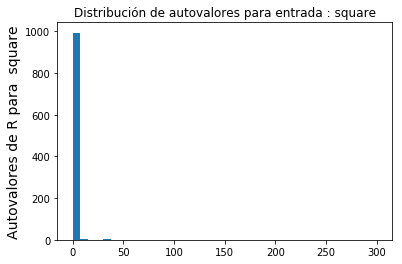

In [61]:
aval = linalg.eigvalsh(R1)
eigenvalues_dist(aval,sound)

Finalmente se considera filtrar la señal de audio original por el filtro obtenido y compararla con el audio grabado con el fin de poder visualizar su correspondencia. Además se obtiene la señal de audio filtrada para ser escuchada

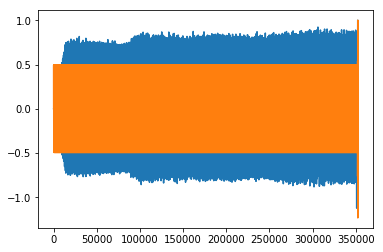

In [62]:
estimado = signal.filtfilt(wo,[1],u)
estimado=estimado/max(estimado)
d = d/max(d)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

In [63]:
Audio(estimado,rate=fs)

###Entrada Ruido Blanco
Tras la señal cuadrada se consideró encontrar el filtro óptimo si la entrada es ruido blanco.

fs de la grabacion  48000 nombre /content/grab_ruido_blanco.wav
fs del audio  48000 nombre /content/ruido_blanco_c.wav


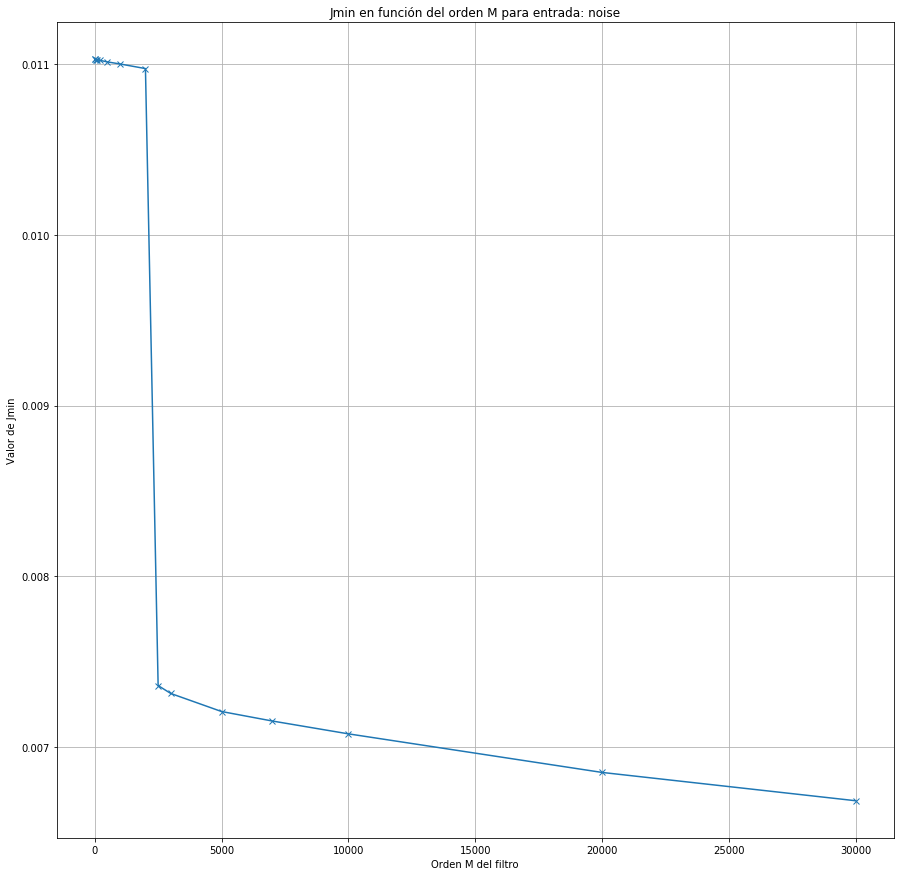

In [64]:
Ms=[1,10,70,100,200,500,1000,2000,2500,3000,5000,7000,10000,20000,30000]

sound="noise"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)


r, p, sigma2d = get_estimations(uZ,dZ)
Jmin = np.zeros(len(Ms))
for i,M in enumerate(Ms):
  r1,R,p1,wo,Jmin[i]= get_filter(r,p,M,sigma2d)

plt.figure(figsize=[15,15])
plt.title("Jmin en función del orden M para entrada: "+ sound)
plt.xlabel("Orden M del filtro")
plt.ylabel("Valor de Jmin")
plt.grid(True)
plt.plot(Ms,Jmin, marker='x')

En este caso se observa que para la cantidad de muestras probadas el valor de Jmin no llega a un valor aproximadamente constante. Sino que posiblemente para ordenes más grandes el resultado sea mejor aun. Sin embargo debido al orden N cubo del algoritmo utilizado para obtener el filtro, se consideró recortar a un N maximo de 30000 muestras, el cual fue tomado como M óptimo final. Para el valor de M óptimo se obtiene el epsilon asociado

In [65]:
Mopt=30000
r1,R1,p1,wo,Jminim= get_filter(r,p,Mopt,sigma2d)
print("El valor de Epsilon  para el M óptimo es: ",Jminim/sigma2d)

El valor de Epsilon  para el M óptimo es:  0.6215203008047538


Igual que en los casos anteriores se considera ver la distribución de autovalores de la matriz R

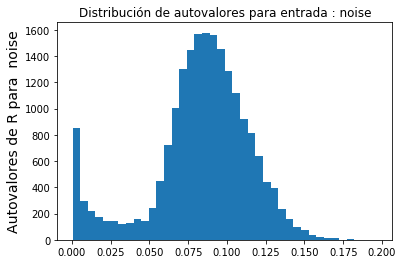

In [66]:
aval = linalg.eigvalsh(R1)
eigenvalues_dist(aval,sound)

Finalmente se considera filtrar la señal de audio original por el filtro obtenido y compararla con el audio grabado con el fin de poder visualizar su correspondencia. Además se obtiene la señal de audio filtrada para ser escuchada

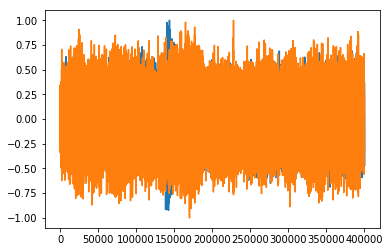

In [67]:
estimado = signal.filtfilt(wo,[1],u)
d = d/max(d)
estimado = estimado/max(estimado)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

In [68]:
Audio(estimado,rate=fs)

###Entrada Señal de Voz
Además se consideró buscar el coeficiente M para el filtro óptimo con una entrada de audio con voz humana

fs de la grabacion  48000 nombre /content/grab_voice.wav
fs del audio  48000 nombre /content/voice_48k.wav


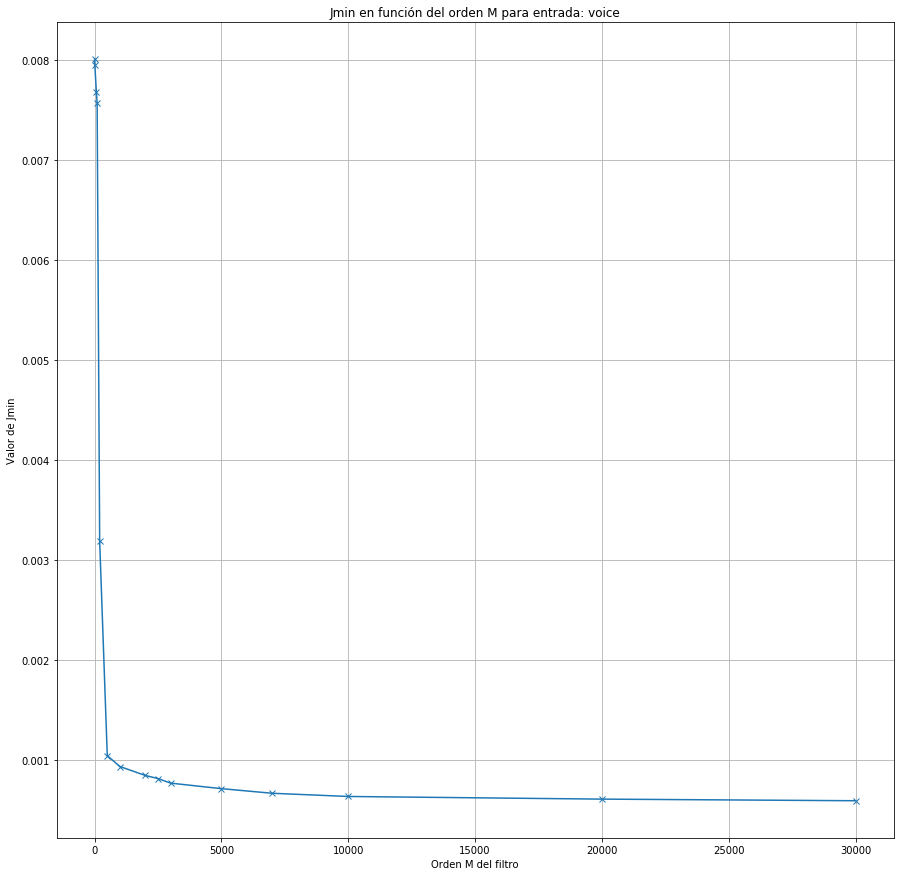

In [69]:
sound="voice"

audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)

r, p, sigma2d = get_estimations(uZ,dZ)
Jmin = np.zeros(len(Ms))
for i,M in enumerate(Ms):
  r1,R,p1,wo,Jmin[i]= get_filter(r,p,M,sigma2d)

plt.figure(figsize=[15,15])
plt.title("Jmin en función del orden M para entrada: "+ sound)
plt.xlabel("Orden M del filtro")
plt.ylabel("Valor de Jmin")
plt.grid(True)
plt.plot(Ms,Jmin, marker='x')

Se observa una rapida mejora de Jmin respecto al orden M del filtro cercano a longitud 100. Despuès se observa una continua leve mejora que se termina manteniendo casi constante hasta el nùmero màximo de longitud probado. Teniendo en cuenta esto se toma como M òptimo M=10000. Para este M se consideró obtener el epsilon asociado.

In [70]:
Mopt=10000
r1,R1,p1,wo,Jminim= get_filter(r,p,Mopt,sigma2d)
print("El valor de Epsilon  para el M óptimo es: ",Jminim/sigma2d)

El valor de Epsilon  para el M óptimo es:  0.07535092295987991


Además se grafican los autovalores de la matriz R

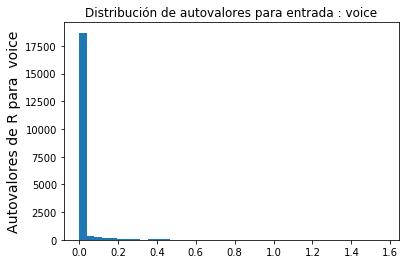

In [71]:
aval = linalg.eigvalsh(R1)
eigenvalues_dist(aval,sound)

Finalmente se considera filtrar la señal de audio original por el filtro obtenido y compararla con el audio grabado con el fin de poder visualizar su correspondencia. Además se obtiene la señal de audio filtrada para ser escuchada

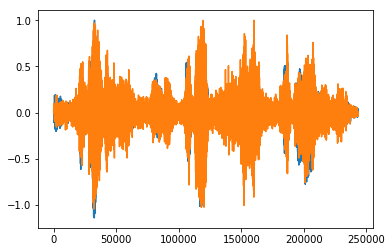

In [72]:
estimado = signal.filtfilt(wo,[1],u)
d = d/max(d)
estimado = estimado/max(estimado)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

In [73]:
Audio(estimado,rate=fs)

###Entrada Señal de Música
Finalmente se consideró ver como quedaba el filtro óptimo si la entrada era una señal de música.

In [5]:
Ms = [i for i in range(1,11)]
Ms = np.concatenate((Ms,[10*i for i in range(2,11)]))
Ms = np.concatenate((Ms,[100*i for i in range(2,11)]))
Ms = np.concatenate((Ms,[1000*i for i in range(2,11)]))
sound="music"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)


r, p, sigma2d = get_estimations(uZ,dZ)
Jmin = np.zeros(len(Ms))
for i,M in enumerate(Ms):
  r1,R,p1,wo,Jmin[i]= get_filter(r,p,M,sigma2d)


fs de la grabacion  48000 nombre /content/grab_cassiopeia.wav
fs del audio  48000 nombre /content/music_original.wav


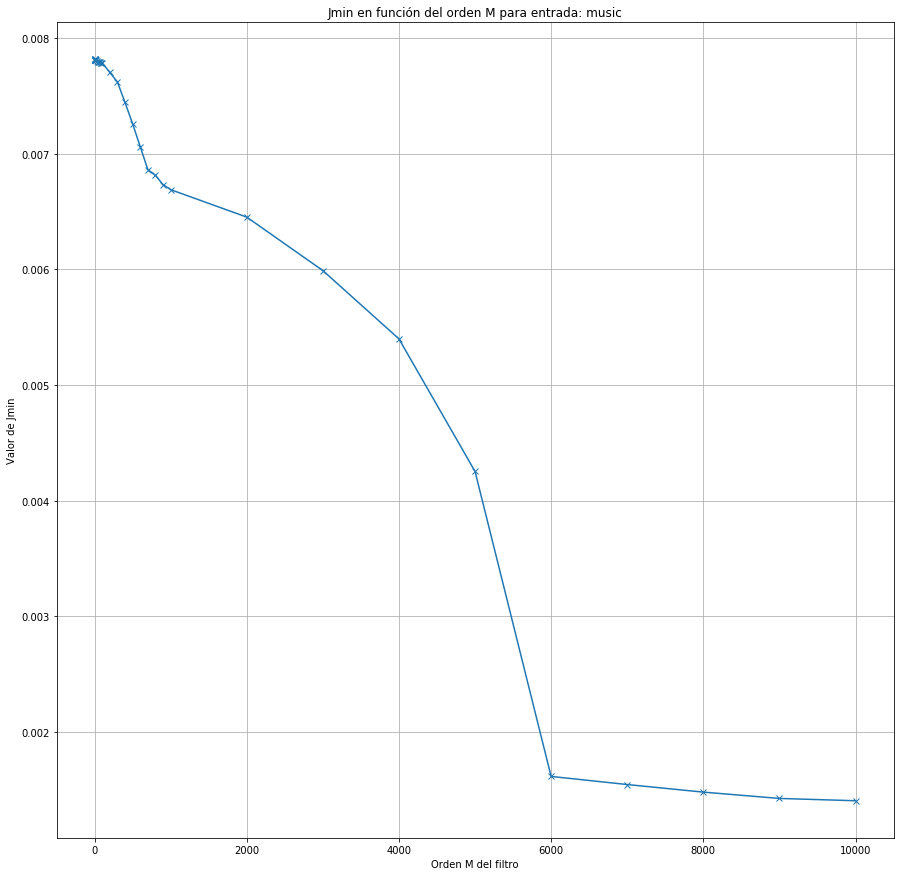

In [6]:
plt.figure(figsize=[15,15])
plt.title("Jmin en función del orden M para entrada: "+ sound)
plt.xlabel("Orden M del filtro")
plt.ylabel("Valor de Jmin")
plt.grid(True)
plt.plot(Ms,Jmin, marker='x')

Se observa una notoria mejora a medida que aumenta el orden M del filtro. Sin embargo despues de M=6000 esta mejora se hace bastante menos notoria y pasa a ser poco significativa. Teniendo en cuenta esto se toma como orden òptimo del filtro M=10000. Para este valor se obtiene el valor de epslion asociado

In [11]:
Mopt=10000
r1,R1,p1,wo,Jminim= get_filter(r,p,Mopt,sigma2d)
print("El valor de Epsilon  para el M óptimo es: ",Jminim/sigma2d)

El valor de Epsilon  para el M óptimo es:  0.17964164149636985


Además se considera obtener la distribución de autovalores de la matriz R del caso

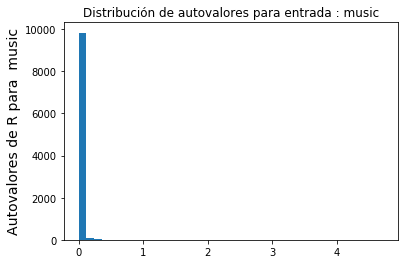

In [12]:
aval = linalg.eigvalsh(R1)
eigenvalues_dist(aval,sound)

Finalmente se considera filtrar la señal de audio original por el filtro obtenido y compararla con el audio grabado con el fin de poder visualizar su correspondencia. Además se obtiene la señal de audio filtrada para ser escuchada

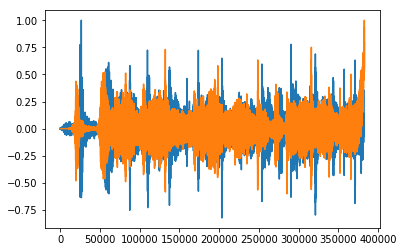

In [13]:
estimado = signal.filtfilt(wo,[1],u)
d = d/max(d)
estimado = estimado/max(estimado)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

In [14]:
Audio(estimado,rate=fs)

##Comparación de resultados

Respecto a la velocidad de convergencia a un Jmin aproximadamente constante se encontró que para el caso de la señal de audio cuadrada la mejora abrupta de Jmin en función de M ocurría para el tamaño de filtro mas pequeño. Sin embargo para este caso se converge a un valor de Jmin que relacionado a la energía de la señal grabada no provee el factor epsilon más pequeño (más deseable) de todos los audios con los que se probó.

El caso en el que para el M óptimo el factor epsilon resulta más pequeño es para el caso de un sweep lineal en frecuencia. Esto puede deberse a que para este tipo de señal se estimula al filtro en todas las bandas espectrales(la señal de salida tiene componentes espectrales en toda la banda de 20Hz a 20kHz). La diferencia de este resultado con el sweep logarítmico puede deberse a que justamente en el sweep lineal se excita a estas componentes espectrales en una manera proporcional mientras en el sweep logarítmico se le da más tiempo a algunas componentes antes que a otras.

Respecto a las otras señales de prueba utilizadas se encontró que para el caso de ruido blanco más coeficientes podrían haber resultado en un mejor desempeño del filtro pero debido al orden cúbico del algoritmo de inversión matricial utilizado se decidió recortar el orden a uno máximo.

Para los casos de Entrada de Voz y de Audio se encuentra que el filtro se adapta de una manera acorde y parece llegar a un valor constante de Jmin por lo que se encuentra correctamente un M óptimo.

Dado que se encontró que el mejor epsilon se daba para la señal de sweep lineal en frecuencia se decidió probar aplicarle el filtro a una señal de audio y ver si la respuesta es acorde a la esperada de la habitación donde se realizaron las mediciones. A continuación se muestra el audio original a probar y luego el audio filtrado por el filtro obtenido con el M óptimo utilizando el sweep lineal en frecuencia.

In [19]:
señal, fs= read_wav("music_signal.wav")
Audio(señal,rate=fs)

fs de la grabacion  48000 nombre music_signal.wav


In [18]:
estimado = sgn.filtfilt(woF,[1],señal)
Audio(estimado,rate=fs)

fs de la grabacion  48000 nombre music_signal.wav


El audio obtenido es acorde a la respuesta de la habitación medida y del microfono utilizado para las grabaciones.